In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from jax import random, nn
from jax import grad, value_and_grad
import jax
import jax.numpy as jnp

In [3]:
def neuron_initialization(architecture, seed = 42):
    
    params = {}
    
    key = random.PRNGKey(seed)
    for i in range(len(architecture)-1):
        
        inputs = architecture[i]
        oputs = architecture[i+1]
        
        initializer = jax.nn.initializers.he_normal()
        #initializer(subkey, (inputs, oputs), jnp.float32) 
        
        key, subkey = random.split(key)
        params[f'w_{i}'] = initializer(subkey, (inputs, oputs), jnp.float32)  #random.uniform(subkey, shape=(inputs, oputs), minval=-1, maxval= 1)     #Weights from neuron to neuron 
        key, subkey = random.split(key)
        params[f'b_{i}'] = initializer(subkey, (1, oputs), jnp.float32)  #random.uniform(subkey, shape=(1, oputs),  minval=-1, maxval= 1)           #Bais vecor for each layer
        
    return params 
    
architecture = [3,4,1,2,6,10]
test_params = neuron_initialization(architecture)
test_params


{'w_0': Array([[-0.62385625,  1.47832   , -0.3503256 ,  0.35584512],
        [-0.6633469 ,  0.72462827,  0.64054126,  0.00546522],
        [ 0.2012313 ,  0.94475996, -1.4384235 , -1.6024474 ]],      dtype=float32),
 'b_0': Array([[ 1.0343399 , -0.19056194,  1.4303523 , -0.5464108 ]], dtype=float32),
 'w_1': Array([[-0.07426444],
        [-0.7407608 ],
        [ 0.652538  ],
        [-0.8679993 ]], dtype=float32),
 'b_1': Array([[0.6802069]], dtype=float32),
 'w_2': Array([[-1.3727881,  0.1614592]], dtype=float32),
 'b_2': Array([[ 0.94661343, -0.31424728]], dtype=float32),
 'w_3': Array([[ 0.03668178,  0.23192246, -1.3957725 ,  1.3753045 , -1.1115527 ,
         -0.2508165 ],
        [-0.44453013, -0.13506305,  1.346293  , -0.08551617, -0.40990335,
          0.9052581 ]], dtype=float32),
 'b_3': Array([[ 1.5526173 , -1.2139907 , -1.2432982 , -2.2786753 ,  0.6723446 ,
         -0.76724064]], dtype=float32),
 'w_4': Array([[-0.01430152,  0.3851388 ,  1.215958  ,  1.0629543 , -0.18833871,


In [4]:
def forward_propagation(params, x_input):
    
    # could this be removed if we utilize back propagation using jax??
    a = x_input
    
    n_layers = int(len(params)/2)
    
    for i in range(n_layers):
        w = params[f'w_{i}']
        b = params[f'b_{i}']
        a_input = a
        
        z = a_input @ w + b
       
        if i < n_layers - 1:
            a = nn.relu(z)           #general simple activation function is used
        else: #problem specific case, for classification we do softmax
            a = nn.softmax(z)
            
        
    return a


architecture = [2,4,1,2,6,2]
test_params = neuron_initialization(architecture)
test_input = jnp.array([1,1])

a = forward_propagation(test_params, test_input)
a

Array([[0.94129837, 0.05870171]], dtype=float32)

In [5]:
def cross_entropy_loss(params, x_input, y_labels, lamba_lasso = 0, lambda_ridge = 0):
    y_probs = forward_propagation(params, x_input)
    log_probs = jnp.log(y_probs) 
    one_hot_labels = nn.one_hot(y_labels, y_probs.shape[-1])  # Convert to one-hot encoding, and use the y_probes dims as the num of classes
    l = -jnp.mean(jnp.sum(one_hot_labels * log_probs, axis=1))
    
    if lamba_lasso != 0:
        l+= lamba_lasso*jnp.sum(jnp.array([jnp.sum(jnp.abs(params[f'w_{i}'])) for i in range(int(len(params) / 2))]))
    if lambda_ridge != 0:
        l+= lambda_ridge*jnp.sum(jnp.array([jnp.sum(params[f'w_{i}'] ** 2) for i in range(int(len(params) / 2))]))
        
    
    return l

architecture = [2,4,1,2,6,2]
test_params = neuron_initialization(architecture)
test_input = jnp.array([[1,1], [2,2]])
test_labesl = jnp.array([0,1])


print(cross_entropy_loss(test_params, test_input, test_labesl))

grad(cross_entropy_loss, argnums=0)(test_params, test_input, test_labesl)

loss_value, Wb_grad = value_and_grad(cross_entropy_loss, argnums=0)(test_params, test_input, test_labesl)
print('loss value', loss_value)
print('grad loss value', Wb_grad)

1.4478908
loss value 1.4478908
grad loss value {'b_0': Array([[0., 0., 0., 0.]], dtype=float32), 'b_1': Array([[0.]], dtype=float32), 'b_2': Array([[0.00221697, 0.        ]], dtype=float32), 'b_3': Array([[0.06043793, 0.        , 0.        , 0.        , 0.        ,
        0.        ]], dtype=float32), 'b_4': Array([[ 0.44129834, -0.4412983 ]], dtype=float32), 'w_0': Array([[0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32), 'w_1': Array([[0.],
       [0.],
       [0.],
       [0.]], dtype=float32), 'w_2': Array([[0., 0.]], dtype=float32), 'w_3': Array([[0.05721135, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]], dtype=float32), 'w_4': Array([[ 0.7004909 , -0.70049083],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]], dtype=float32)}


In [7]:
def schuffel_data(x, y, seed):
    key = jax.random.PRNGKey(seed) 
    permutation = jax.random.permutation(key, x.shape[0])
    return x[permutation], y[permutation]

def batch_generator(x_input, y_target, batch_size, schuffel = True, seed = 42):
    
    n_batches = int(len(y_target)/batch_size)
        
    #x_batches = jnp.zeros(shape=(n_batches, batch_size, x_input.shape[1]))
    #y_batches = jnp.zeros(shape=(n_batches, batch_size))
    
    if schuffel:     
        x_input, y_target = schuffel_data(x_input, y_target, seed)
    
    for i in range(n_batches):
        
        #x_batches = x_batches.at[i].set(x_input[i*batch_size:(i+1)*batch_size,:])
        #y_batches = y_batches.at[i].set(y_target[i*batch_size:(i+1)*batch_size])

        x_batch = jnp.array(x_input[i*batch_size:(i+1)*batch_size,:])
        y_batch = jnp.array(y_target[i*batch_size:(i+1)*batch_size])
    
        yield x_batch, y_batch
    
    #return (x_batches, y_batches)

x_input = jnp.array([[1, 10], [78, 5], [3, 7], [8, 1]]) 
y_target = jnp.array([1, 0, 1, 0])
batch_size = 2

for x_ij, y_ij in batch_generator(x_input, y_target, batch_size):
    print(x_ij)
    print(y_ij)
    print('-----')

[[ 3  7]
 [ 1 10]]
[1 1]
-----
[[78  5]
 [ 8  1]]
[0 0]
-----


In [8]:
def gd_parameter_update(param_grad, params, alpha):
   
    #updating parameters
    updated_params = {}
    for param in params.keys():
        updated_params[param] = params[param] - alpha*param_grad[param]
    
    return updated_params

In [9]:
def standardize_data(x):

    
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    x_std = (x - mean)/(std + 0.0001)

    
    return x_std, mean, std

def data_split(x, y, split_coeff = 0.8):
    n_rows = x.shape[0]
    
    sc_size = int(split_coeff * n_rows)
    
    
    sc_x = x[:sc_size]
    sc_y = y[:sc_size]
    
    sc_inv_x = x[sc_size:]
    sc_inv_y = y[sc_size:]
    
    return sc_x, sc_y, sc_inv_x, sc_inv_y

def prepare_data(x_input, y_target, standerdize = True):


    x_train, y_train, x_test, y_test = data_split(x_input, y_target, 0.8)


    x_train_n, y_train_n, x_train_v, y_train_v = data_split(x_train, y_train, 0.8)


    if standerdize:
        
        #main traing data
        x_std_train, mean_train, std_train = standardize_data(x_train)
        x_train  = x_std_train
        x_test = (x_test - mean_train)/std_train
                
        #Validation
        x_std_train_n, mean_train_n, std_train_n = standardize_data(x_train_n)
        x_train_n = x_std_train_n
        x_train_v = (x_train_v - mean_train_n)/std_train_n

    return x_train, y_train, x_train_n, y_train_n, x_train_v, y_train_v, x_test, y_test
  


In [10]:
def predict(params, x):
    y_probs = forward_propagation(params, x)
    return np.argmax(y_probs, axis=1)

def accuracy(params, x_input, y_target):
    y_pred = predict(params, x_input)
    return np.mean(y_target == y_pred)

In [11]:
def mnist_data_load(percent = 1):
    

    
    train_df = pd.read_csv('../data/mnist_train.csv')
    test_df = pd.read_csv('../data/mnist_test.csv')
    
    all_data = pd.concat([train_df, test_df], ignore_index=True)
    
    n_points = len(all_data)
    
    cut_off_val = int(percent * n_points)
    
    x_df = all_data.drop('label', axis=1)
    y_df = all_data['label']
    
    x_input = x_df.to_numpy()
    y_target = y_df.to_numpy()
    
    
    
    return x_input[:cut_off_val], y_target[:cut_off_val]


In [12]:
def classification_train(params, loss, x_input, y_target, batch_size = 25, epochs = 200, alpha = 0.01):
    history = {'loss_v_epoch': [], 'accuracy_v_epoch': []}
    for i in range(epochs): 
        j = 0
        for x_i_batch, y_i_batch in batch_generator(x_input, y_target, batch_size, schuffel = True, seed = 42): #we go over each batch
            loss_i, param_grad = value_and_grad(loss, argnums=0)(params, x_i_batch, y_i_batch)
            params = gd_parameter_update(param_grad, params, alpha)
           

        history['loss_v_epoch'].append(loss_i)

        print(f'Epoch {i} -> loss: {loss_i}')

            
    return params,  history


def classification_task(architecture, loss_func, x_input, y_tartget, batch_size = 50, epochs = 10, alpha = 0.01):
    #x_input is the numpy array, which then gets convereted to jax in the batching porcces
    params = neuron_initialization(architecture)
    
    #data_proccesing
    x_train, y_train, x_train_n, y_train_n, X_train_v, y_train_v, x_test, y_test = prepare_data
    
    #loss construction
    
    
    
    #hyperparameter selection
    
    
    #Training on full set with choosen hyperparameters
    
    params = classification_train(params, loss, x_train, y_train)
    
    

    
    
    #loggic/plotting info
    
    
    pass

In [13]:
x_input, y_target = mnist_data_load(0.1)
x_input = x_input/255


In [14]:
input_dim = x_input.shape[1]
output_dim = 10 
architecture = [input_dim,  1000, 1000, output_dim]


params = neuron_initialization(architecture)


x_train, y_train, x_test, y_test = data_split(x_input, y_target, split_coeff = 0.8)
#x_train, mean, std = standardize_data(x_train)
#print(std)
#x_test = (x_test - mean)/(std + 0.0001)


param_trained, history = classification_train(params, cross_entropy_loss, x_train, y_train)

accuracy(param_trained, x_test, y_test)

Epoch 0 -> loss: 0.5955199599266052
Epoch 1 -> loss: 0.3522457182407379
Epoch 2 -> loss: 0.26836323738098145


KeyboardInterrupt: 

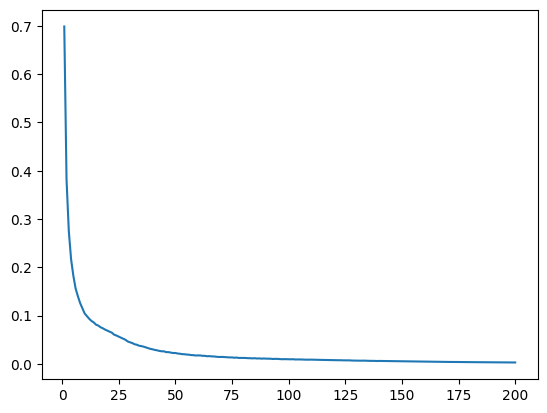

In [35]:
plt.plot(np.linspace(1,200,200), history['loss_v_epoch'])
plt.show()

In [35]:
import preprocessing
dataset_path = "../data/mfeat-pix"

np.random.seed(42)



img_shape = (16, 15)

data = preprocessing.load_data(dataset_path)

num_classes = 10
samples_per_class = 200
train_samples_per_class = 100
test_samples_per_class = 100

train_data, test_data = preprocessing.split_data(data, num_classes, samples_per_class, train_samples_per_class)


train_labels, test_labels = preprocessing.create_labels(num_classes, train_samples_per_class, test_samples_per_class)



architecture = [train_data.shape[1], 128, 128, 128, 128, 128, 128, num_classes]

print(architecture)
params = neuron_initialization(architecture)

param_trained, history = classification_train(params, cross_entropy_loss, train_data, train_labels, epochs=1000, batch_size = 50)

accuracy(param_trained, test_data, test_labels)

[240, 128, 128, 128, 128, 128, 128, 10]
Epoch 0 -> loss: 1.3829962015151978
Epoch 1 -> loss: 0.6392115354537964
Epoch 2 -> loss: 0.37645331025123596
Epoch 3 -> loss: 0.2513224482536316
Epoch 4 -> loss: 0.1911332607269287
Epoch 5 -> loss: 0.149545818567276
Epoch 6 -> loss: 0.12069046497344971
Epoch 7 -> loss: 0.10016915947198868
Epoch 8 -> loss: 0.08070912957191467
Epoch 9 -> loss: 0.066059909760952
Epoch 10 -> loss: 0.05537954717874527
Epoch 11 -> loss: 0.0450667068362236
Epoch 12 -> loss: 0.039858777076005936
Epoch 13 -> loss: 0.03434992581605911
Epoch 14 -> loss: 0.029621759429574013
Epoch 15 -> loss: 0.02661367505788803
Epoch 16 -> loss: 0.0234620850533247
Epoch 17 -> loss: 0.021306714043021202
Epoch 18 -> loss: 0.018983876332640648
Epoch 19 -> loss: 0.017082778736948967
Epoch 20 -> loss: 0.015793470665812492
Epoch 21 -> loss: 0.014236514456570148
Epoch 22 -> loss: 0.013347218744456768
Epoch 23 -> loss: 0.012360374443233013
Epoch 24 -> loss: 0.01158123929053545
Epoch 25 -> loss: 0.0

Array(0.95500004, dtype=float32)

In [ ]:
def hyperparameter_search(params, train_data, train_labels, test_data, test_labels):
    alphas = [0.001, 0.0005, 0.0001]
    lasso_values = [0.01, 0.001, 0.0001]
    ridge_values = [0.1, 0.01, 0.001] 
    batch_sizes = [50, 100]

    best_acc = 0
    best_params = {}

    for alpha, lambda_lasso, lambda_ridge, batch_size in itertools.product(alphas, lasso_values, ridge_values, batch_sizes):
        print(f"\nTesting con: alpha={alpha}, Lasso={lambda_lasso}, Ridge={lambda_ridge}, batch_size={batch_size}")

        params = neuron_initialization(architecture)

        trained_params, history = classification_train_2(
            params, cross_entropy_loss, train_data, train_labels,
            epochs=500, batch_size=batch_size, optimizer="adam",
            alpha=alpha, lambda_lasso=lambda_lasso, lambda_ridge=lambda_ridge
        )

        test_acc = accuracy(trained_params, test_data, test_labels)
        print(f"Test Accuracy: {test_acc:.4f}")

        if test_acc > best_acc:
            best_acc = test_acc
            best_params = {'alpha': alpha, 'lambda_lasso': lambda_lasso, 'lambda_ridge': lambda_ridge, 'batch_size': batch_size}

    print("\nMiglior combinazione trovata:")
    print(f"alpha={best_params['alpha']}, lambda_lasso={best_params['lambda_lasso']}, lambda_ridge={best_params['lambda_ridge']}, batch_size={best_params['batch_size']}")
    print(f"Best Accuracy: {best_acc:.4f}")

    return best_params

In [28]:
accuracy(param_trained, test_data, test_labels)

Array(0.95100003, dtype=float32)